In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [7]:
import sys, os, pathlib
os.environ['PKG_CONFIG_PATH'] = '/ocean/projects/asc170022p/mtragoza/mambaforge/envs/lung-project/lib/pkgconfig'

import numpy as np
import pandas as pd
import nibabel as nib
import meshio
import torch
import warp as wp
wp.config.quiet = True

import matplotlib as mpl
import pyvista as pv

sys.path.append('../..')
import project
from project.core.utils import pprint

torch.cuda.is_available()

True

In [8]:
%autoreload
ds = project.datasets.shapenet.ShapeNetDataset(data_root='../../data/ShapeNetSem')
ds.load_metadata()
ex = next(ds.examples(
    subjects=['wss.101354f9d8dede686f7b08d9de913afe'],
    variant='TEST',
    unit_policy='prefer_metadata'
))
pprint(ex)

Example()
├── dataset:  'ShapeNet'
├── subject:  'wss.101354f9d8dede686f7b08d9de913afe'
├── variant:  'TEST'
├── paths:    dict(len=14)
|   ├── 'source_mesh':   PosixPath('../../data/ShapeNetSem/models-OBJ/models/101354f9d8dede686f7b08d9de913afe.obj')
|   ├── 'source_mask':   PosixPath('../../data/ShapeNetSem/models-binvox-solid/101354f9d8dede686f7b08d9de913afe.binvox')
|   ├── 'surface_mesh':  PosixPath('../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/surface.xdmf')
|   ├── 'binary_mask':   PosixPath('../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/binary.nii.gz')
|   ├── 'region_mask':   PosixPath('../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/regions.nii.gz')
|   ├── 'volume_mesh':   PosixPath('../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/volume.xdmf')
|   ├── 'material_mask': PosixPath('../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/material.nii.gz')
|   ├── 'density_field': Posix

In [24]:
%autoreload
m = project.preprocessing.api.optimize_elasticity_field(
    input_nodes_path=ex.paths['node_values'],
    input_mask_path=ex.paths['region_mask'],
    output_nodes_path=ex.paths['node_values_opt'],
    output_path=ex.paths['elastic_field_opt'],
    unit_m=ex.metadata['unit'],
    solver_kws=dict(eps_reg=1e-5),
    rasterize=True
)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/node_values.xdmf
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/masks/regions.nii.gz
Optimizing elasticity to match observed displacement
Optimizing global parameter(s)
Iteration 0 | loss = 1.1839e+00 | delta = nan | grad = 1.0
Iteration 1 | loss = 1.0579e-01 | delta = 9.1064e-01 | grad = 1.012
Iteration 2 | loss = 1.0579e-01 | delta = 0.0000e+00 | grad = 1.012
Optimization converged
Optimizing local parameter(s)
Iteration 0 | loss = 1.0579e-01 | delta = nan | grad = 1.0
Iteration 1 | loss = 8.1085e-05 | delta = 9.9923e-01 | grad = 0.1949
Iteration 2 | loss = 1.1670e-05 | delta = 8.5608e-01 | grad = 0.2263
Iteration 3 | loss = 4.6273e-06 | delta = 6.0348e-01 | grad = 0.0584
Iteration 4 | loss = 2.5390e-06 | delta = 4.5130e-01 | grad = 0.03276
Iteration 5 | loss = 1.5998e-06 | delta = 3.6990e-01 | grad = 0.08374
Iteration 6 | loss = 1.1882e-06 | delta = 2.5729e-01 | grad = 0.02638
Iteration

In [28]:
m

{'u.norm': 0.6220512819905722,
 'u.rms': 0.9748757944325019,
 'u.rmse': 0.001703411148407065,
 'u.nrmse': 0.0017472962912673071,
 'u.pcorr': 0.9999982085911467,
 'u.scorr': 0.9985133882703672,
 'E.norm': 2646.1635265968853,
 'E.rms': 3235.4061442150014,
 'E.rmse': 812.482337783068,
 'E.nrmse': 0.26735379856286867,
 'E.pcorr': 0.9121839824072315,
 'E.scorr': 0.8645058329307715,
 'res.norm': 0.0700292250452829,
 'res.rms': 0.14065685505097728}

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/elasticity.nii.gz
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/elasticity_opt.nii.gz


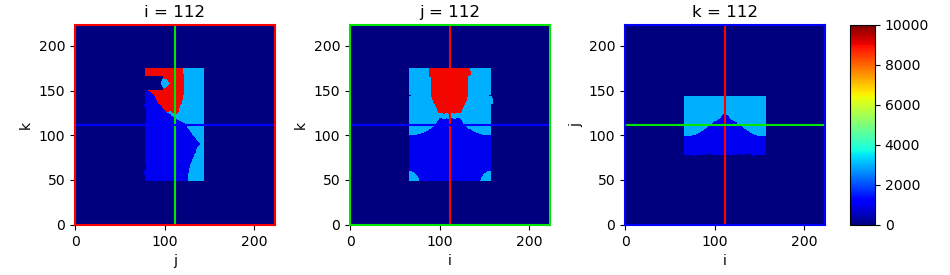

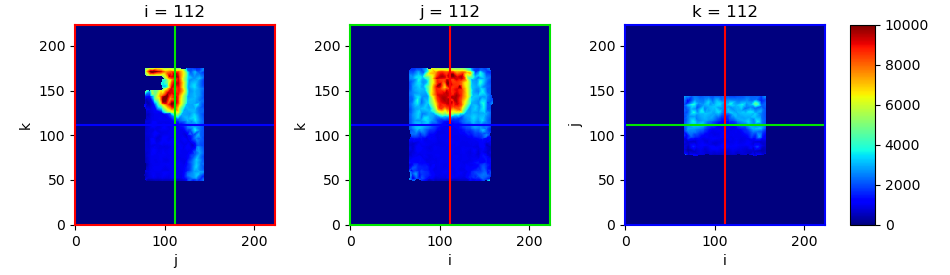

In [27]:
import project.visual.matplotlib

nifti = project.core.fileio.load_nibabel(ex.paths['elastic_field'])
_ = project.visual.matplotlib.show_image_slices(nifti.get_fdata(), cmap='jet', clim=(0, 1e4))

nifti = project.core.fileio.load_nibabel(ex.paths['elastic_field_opt'])
_ = project.visual.matplotlib.show_image_slices(nifti.get_fdata(), cmap='jet', clim=(0, 1e4))

In [23]:
mesh = project.core.fileio.load_meshio(ex.paths['node_values_opt'])
mesh = pv.wrap(mesh)
p = pv.Plotter(window_size=(400,400))
p.add_mesh(mesh, scalars='E_opt', cmap='jet', clim=(0,1e4))
p.show(jupyter_backend='trame')

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/node_values_opt.xdmf


2025-11-05 01:16:37.041 (13090.683s) [    14EDF70B9200]vtkXOpenGLRenderWindow.:1416  WARN| bad X server connection. DISPLAY=


Widget(value='<iframe id="pyvista-jupyter_trame__template_P_0x14ec92a09710_0" src="https://ondemand.bridges2.p…

# Inverse optimization development

In [21]:
mesh_path = ex.paths['volume_mesh']
density_path = ex.paths['density_field']
elastic_path = ex.paths['elastic_field']
unit = ex.metadata['unit']
unit

0.0136197560186615

In [22]:
mesh = project.core.fileio.load_meshio(mesh_path)
density_nifti = project.core.fileio.load_nibabel(density_path)
elastic_nifti = project.core.fileio.load_nibabel(elastic_path)

Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/meshes/volume.xdmf
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/density.nii.gz
Loading ../../data/ShapeNetSem/TEST/101354f9d8dede686f7b08d9de913afe/fields/elasticity.nii.gz


In [8]:
affine_d = density_nifti.affine
affine_e = elastic_nifti.affine
np.allclose(affine_d, affine_e)

True

In [9]:
rho_field = density_nifti.get_fdata().astype(np.float32)
E_field = elastic_nifti.get_fdata().astype(np.float32)
rho_field.shape == E_field.shape

True

In [11]:
import project.core.transforms
pts_voxel = project.core.transforms.world_to_voxel_coords(mesh.points, affine_d)

In [12]:
tensor_kws = dict(dtype=torch.float32, device='cuda')
pts_tensor = torch.as_tensor(pts_voxel, **tensor_kws)
rho_tensor = torch.as_tensor(rho_field, **tensor_kws).unsqueeze(0)
E_tensor = torch.as_tensor(E_field, **tensor_kws).unsqueeze(0)
pts_tensor.shape, rho_tensor.shape, E_tensor.shape

(torch.Size([6846, 3]),
 torch.Size([1, 224, 224, 224]),
 torch.Size([1, 224, 224, 224]))

In [14]:
import project.core.interpolation
rho_nodes = project.core.interpolation.interpolate_image(rho_tensor, pts_tensor)
E_nodes = project.core.interpolation.interpolate_image(E_tensor, pts_tensor)
print(rho_nodes.mean())
print(E_nodes.mean())
rho_nodes.shape, E_nodes.shape

tensor(394.1529, device='cuda:0')
tensor(2411.2158, device='cuda:0')


(torch.Size([6846, 1]), torch.Size([6846, 1]))

In [15]:
nu_value = 0.4
mu_nodes, lam_nodes = project.core.transforms.compute_lame_parameters(E_nodes, nu_value)
bc_nodes = torch.zeros_like(pts_tensor, **tensor_kws)